# Assignment 1 - EigenFaces

## Importing Libraries

In [54]:
import numpy as np
import pandas as pd
import cv2 as cv
import glob
import matplotlib.pyplot as plt

In [2]:
# path if in local 
path = './archive/s*'

# path if in colab
# path = '/content/drive/MyDrive/Pattern/eigen-faces/archive/s*'

## 1. Download the Dataset and Understand the Format (10 Points)
## 2. Generate the Data Matrix and the Label vector (10 Points)

In [3]:
N = 10304
D = np.ones((1, N))

dirs = glob.glob(path)
y = np.array([])
for i, dir in enumerate(dirs, 1):
    for f in glob.glob(dir+"/*"):
        img = cv.imread(f, -1)
        img = np.reshape(img, (1, N))
        D = np.append(D, img, axis=0)
        y = np.append(y, i)

D = D[1:,]  # skip first row (1*N)

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# D_scaled = scaler.fit_transform(D)

# D = D_scaled
print(D.shape)
y = np.array(y)
print(y.shape)

(400, 10304)
(400,)


## 3. Split the Dataset into Training and Test sets (10 Points)

In [4]:
# training => odd
# testing => even
d_train, d_test = D[1::2], D[0::2]
y_train, y_test = y[1::2], y[0::2]


## 4. Classification using PCA (30 points)

In [5]:
d_train.shape

(200, 10304)

In [17]:
# compute mean
mean = np.mean(d_train,axis=0, keepdims=True)
print("Mean shape:", mean.shape)

# center data
Z = d_train - mean
print("Z shape:", Z.shape)

# compute covariance matrix
cov = np.cov(Z.T, bias=True)

# make sure covariance matrix is correct
# std = np.std(Z, axis=0)
# print("Covariance:", cov)
# print("Variance of each diagonal:", std * std)

# compute eigenvalues & eigenvectors
eival, eivec = np.linalg.eigh(cov)

# sort eigenval in descending order & corresponding eigenvec
idx = np.argsort(eival)[::-1]
eival = eival[idx]
eivec = eivec[:,idx]

# add eigenvalues until explained variance >= alpha
eival_sum = np.sum(eival)

Mean shape: (1, 10304)
Z shape: (200, 10304)


In [36]:
alphas = [0.8, 0.85, 0.9, 0.95]
proj_matrices = []
for alpha in alphas:
    # nominator of explained variance
    exp_var_nom = 0
    i = 0
    while(round(exp_var_nom/float(eival_sum), 2) < alpha and i < len(eival)-1):
        exp_var_nom += eival[i]
        i += 1
    print(i-1)
    proj_matrix = eivec[:, :i] # here we don't need to add 1 to i, since we post increment it
    proj_matrices.append(proj_matrix)

34
49
72
110


In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def classify_knn(data_train, labels_train, data_test, labels_test, k=1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data_train, labels_train)
    
    # we can calculate accuracy either way
    
    # labels_pred = knn.predict(data_test)
    #accuracy = metrics.accuracy_score(labels_test, labels_pred)
    
    accuracy = knn.score(data_test, labels_test)
    
    return accuracy

In [49]:
scores = {}

org_accuracy = classify_knn(d_train, y_train, d_test, y_test, k=1)
print("Original accuracy:", org_accuracy)

for proj_matrix, alpha in zip(proj_matrices, alphas):
    d_train_new = np.dot(d_train, proj_matrix)
    d_test_new = np.dot(d_test, proj_matrix)
    
    accuracy = classify_knn(d_train_new, y_train, d_test_new, y_test, k=1)
    scores[alpha] = accuracy
       
print("Accuracy for each alpha:", scores)


Original accuracy: 0.965
Accuracy for each alpha: {0.8: 0.97, 0.85: 0.96, 0.9: 0.96, 0.95: 0.965}


## 5. Classification using LDA (30 points)

In [11]:
# calculate class means
means = np.ones((40, N))

class_matrices = []

for i in range(40):
    class_matrix = d_train[i*5:(i+1)*5,:]
    mean = np.mean(class_matrix, axis=0, keepdims=True)
    means[i] = mean
    class_matrices.append(class_matrix)

overall_mean = np.mean(d_train, axis=0, keepdims=True)
#print(means)

In [12]:
# calculate between-class scatter matrix
nk = 5
Sb = np.zeros((N, N))
for i, mean in enumerate(means):
    mean = mean.reshape(N, 1)
    overall_mean = overall_mean.reshape(N, 1)
    Sb += nk * np.dot((mean - overall_mean), (mean - overall_mean).T)

In [13]:
# calculate center class matrics
Zs = []
for i in range(40):
    Z = class_matrices[i] - means[i]
    Zs.append(Z)

In [ ]:
# calculate class scatter matrices
Ss = []
for i in range(40):
    Si = np.dot(Z)

## 6. Classifier Tuning

a. Set the number of neighbors in the K-NN classifier to 1,3,5,7.

**Tie breaking:**

* We left tie breaking to the default sklearn tie breaking strategy of KNeighborsClassifier

From the documentation for KNeighborsClassifier:

"Warning: Regarding the Nearest Neighbors algorithms, if it is found that two neighbors, neighbor k+1 and k, have identical distances but but different labels, the results will depend on the ordering of the training data."

So, in the case of ties, the answer will be the class that happens to appear first in the set of neighbors.

### 6. 1 PCA Tuning

In [64]:
Ks = [1, 3, 5, 7]

scores = {}

for k in Ks:
    scores_per_k = {}
    for proj_matrix, alpha in zip(proj_matrices, alphas):
        d_train_new = np.dot(d_train, proj_matrix)
        d_test_new = np.dot(d_test, proj_matrix)
        accuracy = classify_knn(d_train_new, y_train, d_test_new, y_test, k=k)
        scores_per_k[alpha] = accuracy
    scores[k] = scores_per_k
    print("K =", k)
    print(scores[k])
    print("\n")


K = 1
{0.8: 0.97, 0.85: 0.96, 0.9: 0.96, 0.95: 0.965}


K = 3
{0.8: 0.91, 0.85: 0.92, 0.9: 0.915, 0.95: 0.91}


K = 5
{0.8: 0.825, 0.85: 0.82, 0.9: 0.825, 0.95: 0.83}


K = 7
{0.8: 0.8, 0.85: 0.795, 0.9: 0.77, 0.95: 0.75}




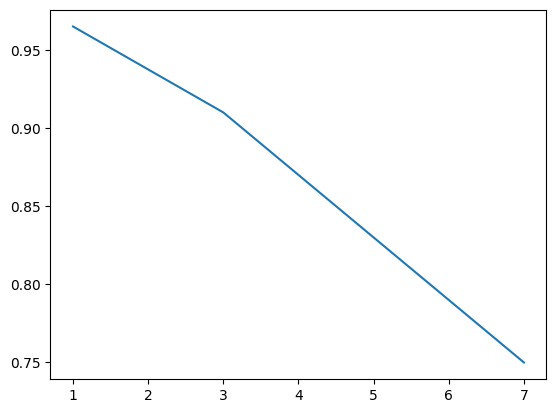

In [67]:
# plotting
max_accs = []

for k in scores:
    max_alpha = max(scores[k])
    max_acc = scores[k][max_alpha]
    max_accs.append(max_acc)
    
plt.plot(Ks, max_accs)
plt.show()

### 6.2 LDA Tuning